# DOG BREED PREDICTION

### In this project we will see how to use Keras and Tensorflow to build, train and test a convolution neural network capable of identifying a breed of a dog in a supplied image. This is supervised learning problem, specifically a multiclass classification problem 

### Uploading the kaggle.json file

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"darshanbhiwapurkar","key":"89cba4b74ce16f426136485d27874e8f"}'}

### Creating a directory and copying the kaggle.json file inside the directory

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json 

### Searching for dog dataset in the kaggle

In [3]:
!kaggle datasets list -s dogbreedidfromcomp

ref                                title                    size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------  ----------------------  -----  -------------------  -------------  ---------  ---------------  
catherinehorng/dogbreedidfromcomp  dog-breed-id-from-comp  691MB  2020-06-26 03:09:05           2396          6  0.1764706        


### Downloading the dataset from kaggle

In [4]:
!mkdir dog_dataset
%cd dog_dataset
!kaggle datasets download catherinehorng/dogbreedidfromcomp

/content/dog_dataset
100% 691M/691M [00:40<00:00, 20.4MB/s]
100% 691M/691M [00:40<00:00, 17.7MB/s]


### Unzip the dataset

In [5]:
%cd ..
!unzip /content/dog_dataset/dogbreedidfromcomp.zip -d dog_dataset

Streaming output truncated to the last 5000 lines.
  inflating: dog_dataset/train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: dog_dataset/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: dog_dataset/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: dog_dataset/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: dog_dataset/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: dog_dataset/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: dog_dataset/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: dog_dataset/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: dog_dataset/train/83fad0718581a696132c96c166472627.jpg  
  inflating: dog_dataset/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: dog_dataset/train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: dog_dataset/train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: dog_dataset/train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: dog_dataset/train/840db91b

### Removing the unnecessary dataset

In [6]:
!rm /content/dog_dataset/dogbreedidfromcomp.zip
!rm /content/dog_dataset/sample_submission.csv

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
import tensorflow as tf
# from keras.preprocessing import image
# from tf.keras.utils import load_img
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam

### Reading the label file and get the shape and number of breeds

In [8]:
labels_all = pd.read_csv('/content/dog_dataset/labels.csv')
print(labels_all.shape)
labels_all.head()

(10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


### No. of classes of breeds

In [10]:
breed_counts.count()

120

### Finding the classes with most labels 

In [9]:
# Taking the breed column from label dataframe
breed_all = labels_all['breed']
# Counting the number for each breed occurance 
breed_counts = breed_all.value_counts()
breed_counts.head()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: breed, dtype: int64

### We will be working on top 3 classes i.e 
### scottish_deerhound, maltese_dog, bernese_mountain_dog       
### Due to limited computational power. Can consider more as well

In [11]:
# Taking the top 3 classes of breed
Classes = ['scottish_deerhound', 'maltese_dog', 'bernese_mountain_dog']
# Getting all data for 3 labels
labels = labels_all[(labels_all['breed'].isin(Classes))]

In [13]:
labels = labels.reset_index()
labels.head()

,index,id,breed
0,9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
1,12,00693b8bc2470375cc744a6391d397ec,maltese_dog
2,79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
3,90,022b34fd8734b39995a9f38a4f3e7b6b,maltese_dog
4,118,02d54f0dfb40038765e838459ae8c956,bernese_mountain_dog


In [36]:
# Creating a numpy array with zeros
# X_data = np.zeros((len(labels),224, 244, 3),dtype='float32')
X_data = []
# One hot encoding the breed labels
Y_data = label_binarize(labels['breed'],classes=Classes)

In [37]:
import cv2
for i in tqdm(range(len(labels))):
  # Loading the image from the training set in same sizes i.e 224,224 
  img = tf.keras.utils.load_img('dog_dataset/train/%s.jpg'% labels['id'][i], target_size=(224,224))
  # img = cv2.imread('dog_dataset/train/%s.jpg'% labels['id'][i])
  # cv2.resize(img, (224,224), interpolation=cv2.INTER_CUBIC)
  # Converting the image into array i.e between 0-255
  img = tf.keras.utils.img_to_array(img)
  # Expanding the 2 dimension of the image into 3 dimension for convolution model
  x = np.expand_dims(img.copy(), axis=0)
  # print(x.shape)
  # Normalization of the image and saving it in the array with zeros 
  X_data.append(x/255.0)

X_data = np.array(X_data).reshape(357,224,224,3)
print("\nTrain images shape:", X_data.shape, "size: {:,}".format(X_data.size))
print("One Hot encoded output shape:", Y_data.shape, "size: {:,}".format(Y_data.size))

100%|██████████| 357/357 [00:01<00:00, 261.46it/s]


Train images shape: (357, 224, 224, 3) size: 53,738,496
One Hot encoded output shape: (357, 3) size: 1,071


### Next we will create a network architecture of the model. We have used different types of layer according to the features namely 
### Conv2D(It is used to create convolution kernel which is colvolued with the input to produce output tensor),
### max_pool2D(It is a downsampling technique which takes out the maximum value over the window defined by the poolsize)
### flatten(It flatten the input and creates a 1D output)
### Dense(Produces output as the dot product of input and kernel)

In [39]:
model = Sequential()
model.add(Conv2D(filters=64, kernel_size = (5,5), activation = 'relu', input_shape = (224,224,3)))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters=32, kernel_size = (3,3), activation = 'relu', kernel_regularizer='l2'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters=16, kernel_size = (7,7), activation = 'relu', kernel_regularizer='l2'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters=8, kernel_size = (5,5), activation = 'relu', kernel_regularizer='l2'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Flatten())
model.add(Dense(128, activation = 'relu', kernel_regularizer='l2'))
model.add(Dense(64, activation = 'relu', kernel_regularizer='l2'))
model.add(Dense(len(Classes), activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer= Adam(0.0001), metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 16)        25104     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 16)      

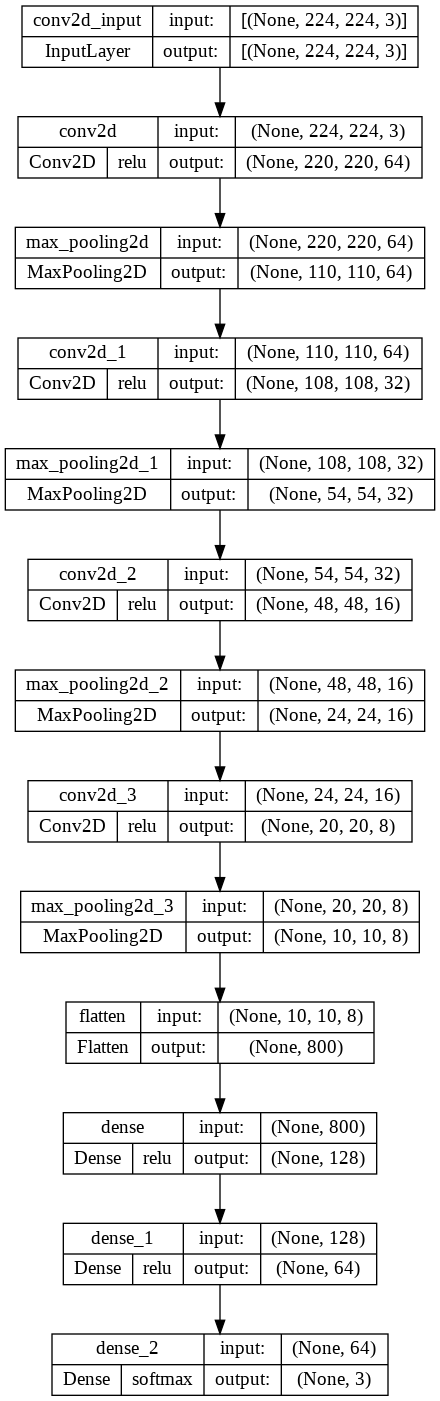

In [40]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file = 'model.png', show_shapes=True, show_layer_activations=True)

### We will split the data into train, test and validation

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size = 0.1) 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2)

### Now we will try our modelat 100 epochs and 128 batch size. You can try using more number of epochs to increase the accuracy. During each epochs we can see how the model is performing by viewing the training and validation accuracy. 

In [42]:
epoch = 100
batch_size = 128
history = model.fit(X_train, y_train, epochs=epoch, batch_size= batch_size, validation_data = (X_val,y_val))

Epoch 1/100
2/2 [==============================] - 14s 2s/step - loss: 4.9096 - accuracy: 0.3086 - val_loss: 4.8838 - val_accuracy: 0.3385
Epoch 2/100
2/2 [==============================] - 1s 410ms/step - loss: 4.8812 - accuracy: 0.3086 - val_loss: 4.8614 - val_accuracy: 0.3538
Epoch 3/100
2/2 [==============================] - 1s 397ms/step - loss: 4.8570 - accuracy: 0.3086 - val_loss: 4.8375 - val_accuracy: 0.3538
Epoch 4/100
2/2 [==============================] - 1s 399ms/step - loss: 4.8315 - accuracy: 0.3047 - val_loss: 4.8131 - val_accuracy: 0.3846
Epoch 5/100
2/2 [==============================] - 1s 402ms/step - loss: 4.8072 - accuracy: 0.3203 - val_loss: 4.7895 - val_accuracy: 0.4000
Epoch 6/100
2/2 [==============================] - 1s 458ms/step - loss: 4.7835 - accuracy: 0.3320 - val_loss: 4.7659 - val_accuracy: 0.4154
Epoch 7/100
2/2 [==============================] - 1s 394ms/step - loss: 4.7596 - accuracy: 0.3555 - val_loss: 4.7422 - val_accuracy: 0.4154
Epoch 8/100
2/2

### Here we will analyse how the model is learning with epoch in terms of accuracy

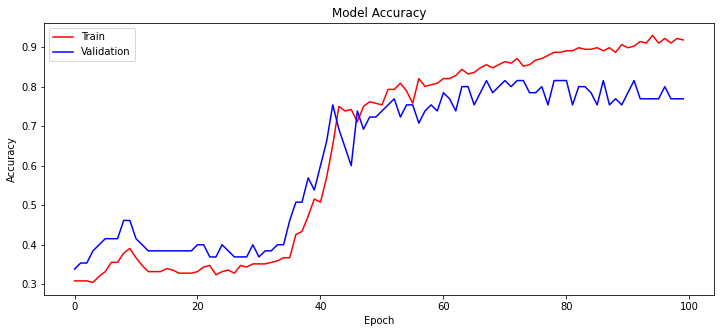

In [43]:
plt.figure(figsize=(12,5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.legend(['Train','Validation'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

### Predicting the accuracy for the test dataset

In [44]:
y_pred = model.predict(X_test)
score = model.evaluate(X_test, y_test)
print(f'Accuracy over the test set : {round((score[1]*100),2)} %')

2/2 [==============================] - 0s 230ms/step - loss: 2.7700 - accuracy: 0.8889
Accuracy over the test set : 88.89 %


### Plot the Image and the value

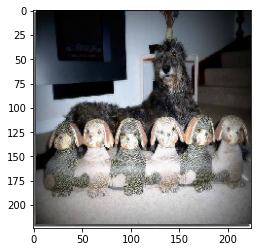

Original: scottish_deerhound
Predicted: scottish_deerhound


In [45]:
plt.imshow(X_test[1,:,:,:])
plt.show()

print(f"Original: {labels['breed'][np.argmax(y_test[1])]}")
print(f"Predicted: {labels['breed'][np.argmax(y_pred[1])]}")

### Conclusion
#### We started with downloading the dataset, creating the model and finding the prediction using the model. We can optimize different hyperparameters inorder to tune this model for a higher accuracy. This model can be used to predict different breeds of dogs which can be further used by different NGO's working on saving animals and for educational purpose only.  

In [46]:
model.save("dog_breed.h5")